In [1]:
import json
import requests
import pandas as pd
from pathlib import Path
import hvplot.pandas
import panel as pn
import holoviews as hv
import numpy as np
from pathlib import Path
from sklearn import cluster, covariance, manifold
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import warnings
warnings.filterwarnings('ignore')


In [2]:
events=pd.read_csv(
    Path('Institutional_Adoption_Events_positive_in_2021.csv'),
    index_col='DATE',
    parse_dates=True,
    infer_datetime_format=True
)
events=events.fillna(0)
events.head()

NEWS    CATEGORY  \
DATE                                                                   
2021-01-05                JP Morgan: BTC Could Hit $146K     Banking   
2021-01-28                     Dorsey Positive BTC Tweet   Corporate   
2021-01-28                       Musk Positive BTC Tweet  Musk Tweet   
2021-02-08                  Tesla Accepts BTC as Payment   Corporate   
2021-02-08  SEC Filing: Tesla Bought $1.5 Billion in BTC  Government   

            Institutional Adopt  
DATE                             
2021-01-05                    1  
2021-01-28                    1  
2021-01-28                    1  
2021-02-08                    1  
2021-02-08                    1

In [3]:
events=events.drop(['NEWS', 'CATEGORY'], axis=1)
events.head()

Institutional Adopt
DATE                           
2021-01-05                    1
2021-01-28                    1
2021-01-28                    1
2021-02-08                    1
2021-02-08                    1

In [4]:
prices=pd.read_csv(
    Path('crypto_market_caps.csv'),
    index_col='date',
    parse_dates=True,
    infer_datetime_format=True

)
prices.head()

spell-token  illuvium  polyswarm  hackenai  mercurial   bitcoin  \
date                                                                          
2021-05-29     0.000000 -0.087474  -0.084921 -0.178955  -0.069173 -0.075526   
2021-05-30     0.231838 -0.029180  -0.077416 -0.050995  -0.020782 -0.021363   
2021-05-31     0.238859  0.067797   0.092618 -0.037861   0.022546  0.022048   
2021-06-01    -0.059507  0.106957   0.026690 -0.004131  -0.004840  0.045575   
2021-06-02    -0.205798 -0.007821  -0.032677  0.333030  -0.024114 -0.014893   

            ethereum    solana  polkadot   cardano  ...   uniswap  antimatter  \
date                                                ...                         
2021-05-29 -0.116392 -0.141745 -0.110146 -0.081747  ... -0.086776   -0.107659   
2021-05-30 -0.048031 -0.045486 -0.063362 -0.056490  ... -0.101236   -0.070963   
2021-05-31  0.035723  0.030508  0.015360  0.099605  ...  0.095878    0.008402   
2021-06-01  0.130062  0.145793  0.143006  0.109167  ...  0.102625    0.202528   
2021-06-02 -0.025359 -0.050999 -0.015254  0.000810  ... -0.030430   -0.194083   

               1inch      aave     maker  lido-dao     serum    audius  \
date                                                                     
2021-05-29 -0.161449 -0.144139 -0.127478 -0.204751 -0.148758 -0.141004   
2021-05-30 -0.058184 -0.062235 -0.049803 -0.049462 -0.048317 -0.080900   
2021-05-31  0.111175  0.081288  0.070708  0.119675  0.043991  0.033885   
2021-06-01  0.106781  0.178813  0.082806  0.195291  0.104627  0.063740   
2021-06-02 -0.023898 -0.023796  0.002862 -0.057441 -0.031295  0.050371   

             arweave   bonfida  
date                            
2021-05-29 -0.074100 -0.154125  
2021-05-30 -0.092101 -0.066768  
2021-05-31  0.081935  0.058975  
2021-06-01  0.081550  0.123031  
2021-06-02  0.002730 -0.042151  

[5 rows x 52 columns]

In [5]:
combined=pd.merge(prices,events,left_index=True, right_index=True)
combined.head()

spell-token  illuvium  polyswarm  hackenai  mercurial   bitcoin  \
2021-01-05          0.0       0.0  -0.088201 -0.122700        0.0 -0.045453   
2021-01-28          0.0       0.0  -0.036659  0.178912        0.0 -0.065799   
2021-01-28          0.0       0.0  -0.036659  0.178912        0.0 -0.065799   
2021-02-08          0.0       0.0   0.071374 -0.045171        0.0 -0.012313   
2021-02-08          0.0       0.0   0.071374 -0.045171        0.0 -0.012313   

            ethereum    solana  polkadot   cardano  ...  antimatter     1inch  \
2021-01-05  0.037039  0.120509 -0.108976  0.046063  ...         0.0 -0.098702   
2021-01-28 -0.087956 -0.084846 -0.098515 -0.098414  ...         0.0 -0.056205   
2021-01-28 -0.087956 -0.084846 -0.098515 -0.098414  ...         0.0 -0.056205   
2021-02-08 -0.041916  0.078294 -0.035286  0.053139  ...         0.0 -0.054602   
2021-02-08 -0.041916  0.078294 -0.035286  0.053139  ...         0.0 -0.054602   

                aave     maker  lido-dao     serum    audius   arweave  \
2021-01-05  0.142612 -0.026812 -0.520328  0.059270 -0.080577  0.018532   
2021-01-28  0.037974 -0.093725 -0.182521 -0.139449 -0.112352 -0.104540   
2021-01-28  0.037974 -0.093725 -0.182521 -0.139449 -0.112352 -0.104540   
2021-02-08  0.017914 -0.047580 -0.051430 -0.023283  0.174763  0.089021   
2021-02-08  0.017914 -0.047580 -0.051430 -0.023283  0.174763  0.089021   

             bonfida  Institutional Adopt  
2021-01-05  0.080724                    1  
2021-01-28 -0.068550                    1  
2021-01-28 -0.068550                    1  
2021-02-08 -0.024576                    1  
2021-02-08 -0.024576                    1  

[5 rows x 53 columns]

In [6]:
combined = combined.dropna(axis=0, how='all')
combined = combined.dropna(axis=1)
combined

spell-token  illuvium  polyswarm  hackenai  mercurial   bitcoin  \
2021-01-05     0.000000  0.000000  -0.088201 -0.122700   0.000000 -0.045453   
2021-01-28     0.000000  0.000000  -0.036659  0.178912   0.000000 -0.065799   
2021-01-28     0.000000  0.000000  -0.036659  0.178912   0.000000 -0.065799   
2021-02-08     0.000000  0.000000   0.071374 -0.045171   0.000000 -0.012313   
2021-02-08     0.000000  0.000000   0.071374 -0.045171   0.000000 -0.012313   
2021-02-10     0.000000  0.000000   0.030380  0.017489   0.000000  0.005509   
2021-03-01     0.000000  0.000000  -0.001941 -0.020123   0.000000 -0.036040   
2021-03-04     0.000000  0.000000   0.255754 -0.071696   0.000000  0.041480   
2021-03-17     0.000000  0.000000   0.196822  0.118644   0.000000  0.010508   
2021-03-17     0.000000  0.000000   0.196822  0.118644   0.000000  0.010508   
2021-03-24     0.000000  0.000000  -0.021293 -0.063744   0.000000 -0.002944   
2021-03-29     0.000000  0.000000   0.085567  0.013895   0.000000 -0.002735   
2021-04-14     0.000000 -0.068583  -0.048442  0.041246   0.000000  0.061870   
2021-05-24     0.000000 -0.200113  -0.135245 -0.093313  -0.344053 -0.067771   
2021-06-06    -0.215578 -0.011126  -0.008773 -0.082528   0.004229 -0.041683   
2021-06-13     3.748313  0.015434   0.058805  0.002835  -0.032985 -0.043490   
2021-07-25    -0.041375  0.128839  -0.004607 -0.000175  -0.002309  0.022725   
2021-07-30     0.023925  0.073627   0.010816 -0.005498  -0.005968 -0.001282   
2021-08-17    -0.006275 -0.109989  -0.173071 -0.147604   0.090888 -0.018685   
2021-08-24     0.036256  0.085720  -0.033546  0.186568  -0.018165  0.005509   
2021-09-09     0.024950  0.029665   0.055418  0.049304  -0.001717 -0.017074   
2021-09-14     0.043225 -0.014073  -0.065477 -0.057108  -0.114027 -0.023161   
2021-09-24     0.060892  0.078953  -0.005927 -0.011940   0.053726  0.031878   
2021-10-01     0.078189  0.064448   0.005848  0.004769   0.008471  0.057773   
2021-10-05     0.196388 -0.002734   0.673805  0.024428  -0.013744  0.019203   

            ethereum    solana  polkadot   cardano  ...  antimatter     1inch  \
2021-01-05  0.037039  0.120509 -0.108976  0.046063  ...    0.000000 -0.098702   
2021-01-28 -0.087956 -0.084846 -0.098515 -0.098414  ...    0.000000 -0.056205   
2021-01-28 -0.087956 -0.084846 -0.098515 -0.098414  ...    0.000000 -0.056205   
2021-02-08 -0.041916  0.078294 -0.035286  0.053139  ...    0.000000 -0.054602   
2021-02-08 -0.041916  0.078294 -0.035286  0.053139  ...    0.000000 -0.054602   
2021-02-10  0.022061 -0.000492  0.009954  0.031103  ...    0.000000 -0.039151   
2021-03-01 -0.027074 -0.005707  0.007087 -0.002945  ...   -0.029627 -0.077908   
2021-03-04  0.058806  0.010639  0.024888 -0.005755  ...    0.115919  0.018717   
2021-03-17 -0.000993 -0.039405  0.024902  0.198186  ...    0.062740  0.159021   
2021-03-17 -0.000993 -0.039405  0.024902  0.198186  ...    0.062740  0.159021   
2021-03-24 -0.015586 -0.050000 -0.035736  0.008444  ...    0.126689 -0.054469   
2021-03-29 -0.016649  0.090198 -0.015048  0.008187  ...    0.039810  0.018431   
2021-04-14  0.072893 -0.024895  0.063210  0.080987  ...    0.069774  0.016664   
2021-05-24 -0.090997 -0.222345 -0.184359 -0.102852  ...   -0.176038 -0.135303   
2021-06-06 -0.032741  0.033095 -0.055998 -0.030800  ...   -0.005209  0.063602   
2021-06-13  0.020075  0.026782 -0.005058  0.038775  ...   -0.009050  0.013352   
2021-07-25  0.032196  0.010471  0.035422  0.022234  ...    0.083854 -0.029775   
2021-07-30  0.037000  0.132701  0.052022  0.006224  ...    0.089826  0.033864   
2021-08-17 -0.044803  0.208291  0.080192 -0.029940  ...   -0.027760  0.012786   
2021-08-24  0.023272  0.049115  0.005238  0.101750  ...    0.014955  0.008542   
2021-09-09  0.023114  0.083879 -0.006899 -0.002273  ...    0.107324 -0.006061   
2021-09-14 -0.036988 -0.035371 -0.032827 -0.074156  ...   -0.185908 -0.048143   
2021-09-24  0.032906  0.012704  0.065797  0.040253  ...    0.119120  0.064217   
2021-10-01  0

In [7]:
combined_new=combined.drop(['Institutional Adopt'], axis=1)
combined_new

spell-token  illuvium  polyswarm  hackenai  mercurial   bitcoin  \
2021-01-05     0.000000  0.000000  -0.088201 -0.122700   0.000000 -0.045453   
2021-01-28     0.000000  0.000000  -0.036659  0.178912   0.000000 -0.065799   
2021-01-28     0.000000  0.000000  -0.036659  0.178912   0.000000 -0.065799   
2021-02-08     0.000000  0.000000   0.071374 -0.045171   0.000000 -0.012313   
2021-02-08     0.000000  0.000000   0.071374 -0.045171   0.000000 -0.012313   
2021-02-10     0.000000  0.000000   0.030380  0.017489   0.000000  0.005509   
2021-03-01     0.000000  0.000000  -0.001941 -0.020123   0.000000 -0.036040   
2021-03-04     0.000000  0.000000   0.255754 -0.071696   0.000000  0.041480   
2021-03-17     0.000000  0.000000   0.196822  0.118644   0.000000  0.010508   
2021-03-17     0.000000  0.000000   0.196822  0.118644   0.000000  0.010508   
2021-03-24     0.000000  0.000000  -0.021293 -0.063744   0.000000 -0.002944   
2021-03-29     0.000000  0.000000   0.085567  0.013895   0.000000 -0.002735   
2021-04-14     0.000000 -0.068583  -0.048442  0.041246   0.000000  0.061870   
2021-05-24     0.000000 -0.200113  -0.135245 -0.093313  -0.344053 -0.067771   
2021-06-06    -0.215578 -0.011126  -0.008773 -0.082528   0.004229 -0.041683   
2021-06-13     3.748313  0.015434   0.058805  0.002835  -0.032985 -0.043490   
2021-07-25    -0.041375  0.128839  -0.004607 -0.000175  -0.002309  0.022725   
2021-07-30     0.023925  0.073627   0.010816 -0.005498  -0.005968 -0.001282   
2021-08-17    -0.006275 -0.109989  -0.173071 -0.147604   0.090888 -0.018685   
2021-08-24     0.036256  0.085720  -0.033546  0.186568  -0.018165  0.005509   
2021-09-09     0.024950  0.029665   0.055418  0.049304  -0.001717 -0.017074   
2021-09-14     0.043225 -0.014073  -0.065477 -0.057108  -0.114027 -0.023161   
2021-09-24     0.060892  0.078953  -0.005927 -0.011940   0.053726  0.031878   
2021-10-01     0.078189  0.064448   0.005848  0.004769   0.008471  0.057773   
2021-10-05     0.196388 -0.002734   0.673805  0.024428  -0.013744  0.019203   

            ethereum    solana  polkadot   cardano  ...   uniswap  antimatter  \
2021-01-05  0.037039  0.120509 -0.108976  0.046063  ... -0.063158    0.000000   
2021-01-28 -0.087956 -0.084846 -0.098515 -0.098414  ...  0.090114    0.000000   
2021-01-28 -0.087956 -0.084846 -0.098515 -0.098414  ...  0.090114    0.000000   
2021-02-08 -0.041916  0.078294 -0.035286  0.053139  ... -0.040114    0.000000   
2021-02-08 -0.041916  0.078294 -0.035286  0.053139  ... -0.040114    0.000000   
2021-02-10  0.022061 -0.000492  0.009954  0.031103  ...  0.018177    0.000000   
2021-03-01 -0.027074 -0.005707  0.007087 -0.002945  ... -0.049854   -0.029627   
2021-03-04  0.058806  0.010639  0.024888 -0.005755  ... -0.000634    0.115919   
2021-03-17 -0.000993 -0.039405  0.024902  0.198186  ...  0.001373    0.062740   
2021-03-17 -0.000993 -0.039405  0.024902  0.198186  ...  0.001373    0.062740   
2021-03-24 -0.015586 -0.050000 -0.035736  0.008444  ... -0.068642    0.126689   
2021-03-29 -0.016649  0.090198 -0.015048  0.008187  ... -0.013734    0.039810   
2021-04-14  0.072893 -0.024895  0.063210  0.080987  ... -0.041901    0.069774   
2021-05-24 -0.090997 -0.222345 -0.184359 -0.102852  ... -0.174898   -0.176038   
2021-06-06 -0.032741  0.033095 -0.055998 -0.030800  ... -0.041331   -0.005209   
2021-06-13  0.020075  0.026782 -0.005058  0.038775  ... -0.015698   -0.009050   
2021-07-25  0.032196  0.010471  0.035422  0.022234  ... -0.015159    0.083854   
2021-07-30  0.037000  0.132701  0.052022  0.006224  ...  0.027683    0.089826   
2021-08-17 -0.044803  0.208291  0.080192 -0.029940  ... -0.020861   -0.027760   
2021-08-24  0.023272  0.049115  0.005238  0.101750  ...  0.013242    0.014955   
2021-09-09  0.023114  0.083879 -0.006899 -0.002273  ... -0.045788    0.107324   
2021-09-14 -0.036988 -0.035371 -0.032827 -0.074156  ... -0.045445   -0.185908   
2021-09-24  0.032906  0.012704  0.065797  0.040253  ...  0.004292    0.119120   
2021-10-01  0

In [8]:
variation = combined_new
variation.shape

(25, 52)

In [9]:
column_names= list(combined_new)

In [12]:
# calculate mean and variance for each token
annual_returns = []
variance = []
for x in column_names:
    annual_returns.append(combined_new[x].mean()*252)
    variance.append(combined_new[x].std()*np.sqrt(252))
    
    

In [13]:
stats=pd.DataFrame([annual_returns,variance])

In [14]:
stats_df=stats.T

In [31]:
stats_df.columns=('annual_return','variance')

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [30]:
stats_df.index=column_names

In [17]:
stats_df.head()

annual_return   variance
spell-token      39.805005  11.917818
illuvium          0.706303   1.013636
polyswarm        10.613691   2.601856
hackenai          1.702293   1.451243
mercurial        -3.786581   1.206435

In [18]:
# Create a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

In [19]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(stats_df)
    inertia.append(k_model.inertia_)

In [20]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

k      inertia
0  1  2635.101536
1  2  1064.530580
2  3   375.962039
3  4   175.422859
4  5    93.053686

In [32]:
# Plot the DataFrame
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

In [22]:
# Create and initialize the K-means model instance for 4 clusters
model = KMeans(n_clusters=4, random_state=1)

In [23]:
# Fit the data to the instance of the model
model.fit(stats_df)

# Make predictions about the data clusters using the trained model
crypto_clusters = model.predict(stats_df)
crypto_clusters

array([1, 3, 2, 3, 0, 0, 0, 3, 0, 3, 2, 2, 3, 0, 0, 3, 2, 2, 3, 0, 0, 3,
       0, 0, 3, 3, 2, 3, 0, 2, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3,
       0, 3, 0, 0, 0, 3, 3, 0], dtype=int32)

In [24]:
len(crypto_clusters)

52

In [25]:
crypto_clusters_df = pd.DataFrame(crypto_clusters)
crypto_clusters_df.head()

0
0  1
1  3
2  2
3  3
4  0

In [26]:
stats_df['crypto_cluster']=crypto_clusters
stats_df['names']=column_names
stats_df


annual_return   variance  crypto_cluster  \
spell-token                    39.805005  11.917818               1   
illuvium                        0.706303   1.013636               3   
polyswarm                      10.613691   2.601856               2   
hackenai                        1.702293   1.451243               3   
mercurial                      -3.786581   1.206435               0   
bitcoin                        -1.910961   0.573970               0   
ethereum                       -1.173550   0.735166               0   
solana                          3.669167   1.361324               3   
polkadot                       -3.041666   0.994240               0   
cardano                         4.487687   1.208479               3   
dogecoin                        7.064480   2.268035               2   
terra-luna                      8.085814   2.071973               2   
avalanche-2                     4.353216   1.693084               3   
litecoin                       -2.375296   0.829543               0   
bitcoin-cash                   -3.637396   0.885443               0   
cosmos                          3.914632   1.066713               3   
matic-network                  10.356925   1.987069               2   
filecoin                        9.461377   2.024270               2   
stellar                         1.829506   0.954872               3   
vechain                        -1.897772   1.450755               0   
axie-infinity                  -1.177466   1.511801               0   
thorchain                       4.479251   1.239222               3   
sushi                          -8.525471   0.921143               0   
compound-governance-token      -2.199285   0.760546               0   
monero                          0.782946   0.703352               3   
fantom                          2.364363   1.348907               3   
algorand                       11.485060   4.102645               2   
tezos                           5.162437   1.019609               3   
waves                          -0.627993   1.199252               0   
harmony                         8.469291   2.262380               2   
zilliqa                        -1.358851   1.508314               0   
flow                            1.934135   0.974703               3   
flux                            2.982204   2.046509               3   
chainlink                      -2.935302   0.914820               0   
band-protocol                  -0.776656   1.127048               0   
huobi-token                     0.817308   1.302784               3   
yearn-finance                  -1.854784   0.820534               0   
bitcoin-gold                   -1.887476   0.771929               0   
curve-dao-token                -1.775238   1.585609               0   
augur                           2.620035   2.259436               3   
api3                            2.815462   1.745186               3   
dia-data                       -2.558346   1.195444               0   
uniswap                        -4.435760   0.822974               0   
antimatter                      5.729095   1.250114               3   
1inch                          -0.876663   1.107081               0   
aave                            1.893657   0.759767               3   
maker                          -2.280088   0.664944               0   
lido-dao                       -8.991451   2.197826               0   
serum                          -2.672408   1.325717               0   
audius                          4.580490   2.298672               3   
arweave                         1.834874   1.734510               3   
bonfida                        -0.403963   1.184937               0   

                                               names  
spell-token                              spell-token  
illuvium                                    illuvium  
polyswarm                                  polyswarm  
hackenai                                   

In [28]:
# Plot the crypto clusters Data Frame
stats_df.hvplot.scatter(x="annual_return", y="variance", by="crypto_cluster",text='names',text_baseline='top',hover=True)
#stats_df.hvplot.labels(x='annual_return', y='variance',by='crypto_cluster', text='names',text_baseline='top', hover=True)

:NdOverlay   [crypto_cluster]
   :Scatter   [annual_return]   (variance)

In [126]:
correlations_df=combined_new.corr()
btc_correlations=correlations_df.loc['bitcoin']

In [128]:
btc_correlations=btc_correlations.sort_values()

btc_correlations.hvplot.scatter()

:Scatter   [index]   (bitcoin)

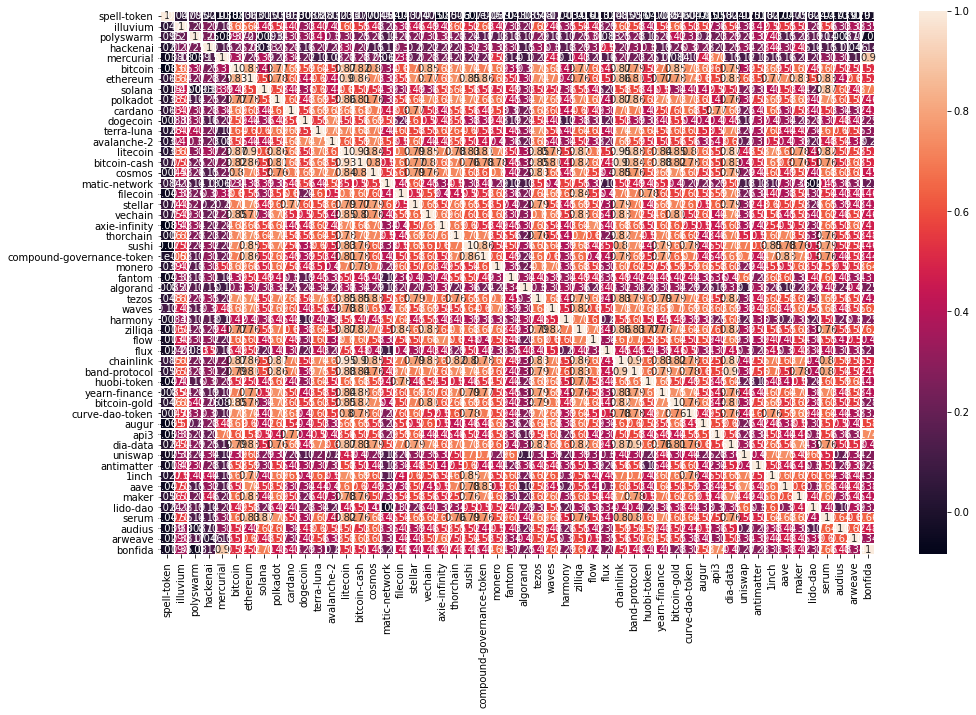

In [135]:
plt.figure(figsize = (16,10))
ax = sns.heatmap(correlations_df, annot=True, linewidths=.5)


In [204]:
correlations_df

spell-token  illuvium  polyswarm  hackenai  \
spell-token                   1.000000  0.046561   0.094805  0.020756   
illuvium                      0.046561  1.000000   0.209217  0.273235   
polyswarm                     0.094805  0.209217   1.000000  0.249664   
hackenai                      0.020756  0.273235   0.249664  1.000000   
mercurial                    -0.038072  0.178246  -0.038955  0.147902   
bitcoin                      -0.082778  0.656494   0.367388  0.251696   
ethereum                      0.062578  0.643758   0.266252  0.279630   
solana                        0.014987  0.448241  -0.009303  0.032555   
polkadot                      0.037968  0.541015   0.140796  0.253279   
cardano                       0.062622  0.466929   0.327459  0.283781   
dogecoin                     -0.008827  0.332559   0.329015  0.156257   
terra-luna                    0.027565  0.469153   0.410703  0.266911   
avalanche-2                   0.031968  0.414795   0.301353  0.233291   
litecoin                      0.032683  0.612709   0.306888  0.371508   
bitcoin-cash                  0.077102  0.554407   0.250199  0.267267   
cosmos                       -0.004473  0.483126   0.263635  0.151775   
matic-network                 0.083741  0.246939   0.136685  0.132584   
filecoin                     -0.042529  0.381703   0.260195  0.298819   
stellar                       0.073749  0.458281   0.273459  0.202125   
vechain                       0.075039  0.486177   0.312317  0.216467   
axie-infinity                -0.085322  0.430969   0.335829  0.224320   
thorchain                     0.006046  0.621825   0.277594  0.230580   
sushi                        -0.069609  0.519818   0.244021  0.317491   
compound-governance-token     0.000031  0.629688   0.169862  0.310162   
monero                        0.038855  0.468896   0.175828  0.325935   
fantom                       -0.042853  0.332152   0.181057  0.308699   
algorand                      0.008534  0.273183   0.165388  0.146777   
tezos                         0.047918  0.618778   0.288563  0.348559   
waves                         0.117093  0.464954   0.182051  0.296628   
harmony                      -0.003440  0.346258   0.172704  0.182738   
zilliqa                      -0.015744  0.544568   0.252042  0.287467   
flow                         -0.013490  0.476801   0.311319  0.320832   
flux                         -0.024010  0.287163   0.082597  0.498640   
chainlink                     0.085040  0.624038   0.254019  0.267843   
band-protocol                 0.056437  0.584982   0.281875  0.313045   
huobi-token                  -0.047498  0.411754   0.163201  0.297958   
yearn-finance                 0.008491  0.540067   0.257928  0.189937   
bitcoin-gold                  0.045932  0.655355   0.424314  0.258017   
curve-dao-token              -0.004701  0.528405   0.327766  0.301596   
augur                        -0.064612  0.567489   0.197677  0.280382   
api3                         -0.058259  0.356320   0.228790  0.209496   
dia-data                      0.024203  0.542762   0.294595  0.246193   
uniswap                      -0.024849  0.333566   0.243908  0.335642   
antimatter                   -0.018013  0.419405   0.367302  0.275980   
1inch                         0.027066  0.500925   0.430148  0.438543   
aave                         -0.047089  0.547401   0.147856  0.324184   
maker                         0.055656  0.513702   0.233916  0.464944   
lido-dao                      0.023666  0.275377   0.191077  0.135623   
serum                        -0.046619  0.555976   0.137770  0.148273   
audius                       -0.039296  0.326874   0.008707  0.111074   
arweave                      -0.029301  0.381906   0.171940  0.046294   
bonfida                      -0.019236  0.351981  -0.030442  0.142799   

                           mercurial   bitcoin  ethereum    solana  polkadot  \
spell-token                -0.038072 -0.082778  0.062578  0.014987  0.037968 

In [ ]:
# Plot the DataFrame
# Visualization
plt.figure(1, facecolor='w', figsize=(12, 9))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')


#Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)


# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)

# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)


# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))
plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())
plt.show()